In [1]:
import numpy as np
import re
import os
import glob
from astropy.time import Time
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

In [2]:
directory = '/Users/bryna/Projects/Physics/HERA/h2c/'
h2c_files = glob.glob(os.path.join(directory,'acc_*.dat'))
n_files = len(h2c_files)

In [3]:
n_ants = np.zeros(n_files, dtype=int)
n_baselines = np.zeros(n_files, dtype=int)
max_ew = np.zeros(n_files)
mean_ew = np.zeros(n_files)
max_ns = np.zeros(n_files)
mean_ns = np.zeros(n_files)
max_len = np.zeros(n_files)
mean_len = np.zeros(n_files)
pos_dict = {}
uvw_dict = {}
dates = []

In [4]:
for f_ind, filename in enumerate(h2c_files):
    date_str = re.findall(r'\d+', os.path.basename(filename))[0]
    dates.append(Time('20' + date_str[0:2] + '-' + date_str[2:4] + '-' + date_str[4:6] + 'T00:00:00', scale='utc'))
    ant_names = np.loadtxt(filename, usecols=0, dtype=str)
    ant_nums = [int(re.findall(r'\d+', name)[0]) for name in ant_names]
    data = np.loadtxt(filename, usecols=(1,2,3))
    eastings = data[:, 0]
    northings = data[:, 1]
    altitudes = data[:, 2]
    pos_dict[f_ind] = np.array([eastings,northings,altitudes]).T
    n_ants[f_ind] = ant_names.shape[0]
    n_baselines[f_ind] = int(n_ants[f_ind] * (n_ants[f_ind]-1) / 2)

    uvw_array = np.zeros((n_baselines[f_ind], 3), dtype = float)
    ant1_array = np.zeros(n_baselines[f_ind], dtype = int)
    ant2_array = np.zeros(n_baselines[f_ind], dtype = int)
    bl_ind = 0
    for ind1, ant1 in enumerate(ant_nums):
        for ind2, ant2 in enumerate(ant_nums):
            if ant1 < ant2:
                ant1_array[bl_ind] = ant1
                ant2_array[bl_ind] = ant2
                uvw_array[bl_ind, :] = [eastings[ind1] - eastings[ind2], northings[ind1] - northings[ind2],
                                        altitudes[ind1] - altitudes[ind2]]
                bl_ind += 1
    uvw_dict[f_ind] = uvw_array
    max_ew[f_ind] = np.max(abs(uvw_array[:,0]))
    mean_ew[f_ind] = np.mean(abs(uvw_array[:,0]))
    max_ns[f_ind] = np.max(abs(uvw_array[:,1]))
    mean_ns[f_ind] = np.mean(abs(uvw_array[:,1]))
    max_len[f_ind] = np.max(np.linalg.norm(uvw_array, axis=1))
    mean_len[f_ind] = np.mean(np.linalg.norm(uvw_array, axis=1))

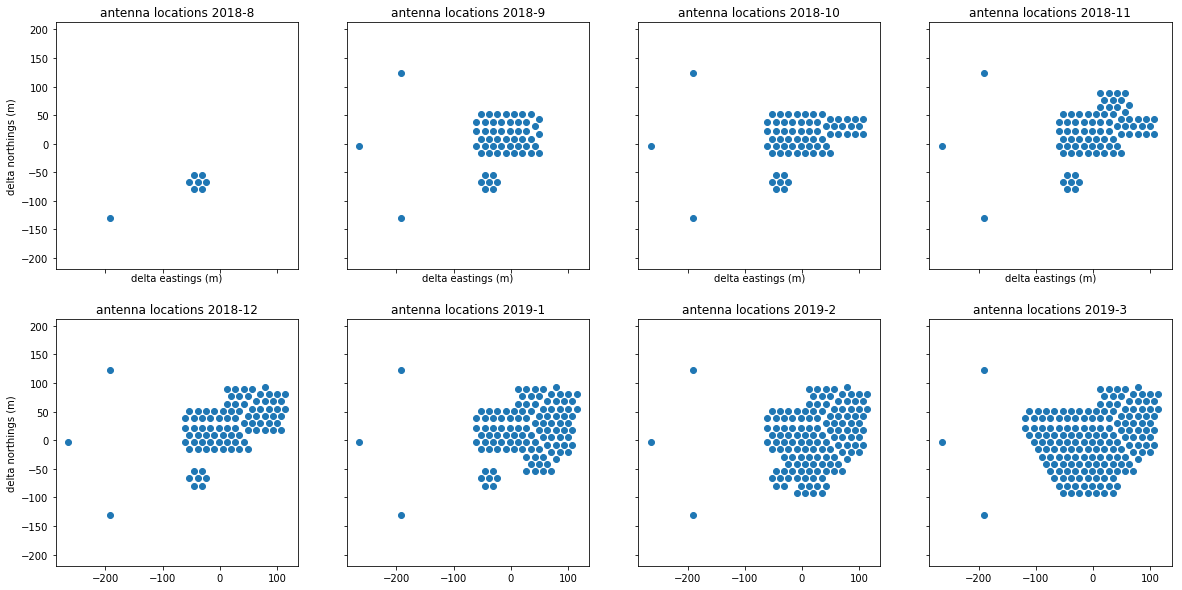

In [5]:
n_col = 4
n_row = int(np.ceil(n_files / float(n_col)))
matplotlib.rcParams['figure.figsize'] = (5*n_col,5*n_row)

array_center = np.mean(pos_dict[n_files-1], axis=0)
plot_ew = np.array([-1,1]) * np.ceil(np.max(abs(pos_dict[n_files-1][:,0] - array_center[0]), axis=0)/20)*20
plot_ns = np.array([-1,1]) * np.ceil(np.max(abs(pos_dict[n_files-1][:,1] - array_center[1]), axis=0)/20)*20

plt.figure(1)
fig, axes = plt.subplots(n_row, n_col, sharex='col', sharey='row')
for ind in range(n_files):
    row_num = ind % n_col
    col_num = ind / n_col
    positions = pos_dict[ind]
 
    axes[col_num, row_num].scatter(positions[:, 0] - array_center[0], positions[:, 1] - array_center[1])
    if row_num == 0:
        axes[col_num, row_num].set_ylabel("delta northings (m)")
    if col_num == 0:
        axes[col_num, row_num].set_xlabel("delta eastings (m)")
    axes[col_num, row_num].set_aspect('equal', 'datalim')
    axes[col_num, row_num].set_title('antenna locations {yr}-{mo}'.format(yr=dates[ind].datetime.year, mo=dates[ind].datetime.month))

plt.show()
plt.close()

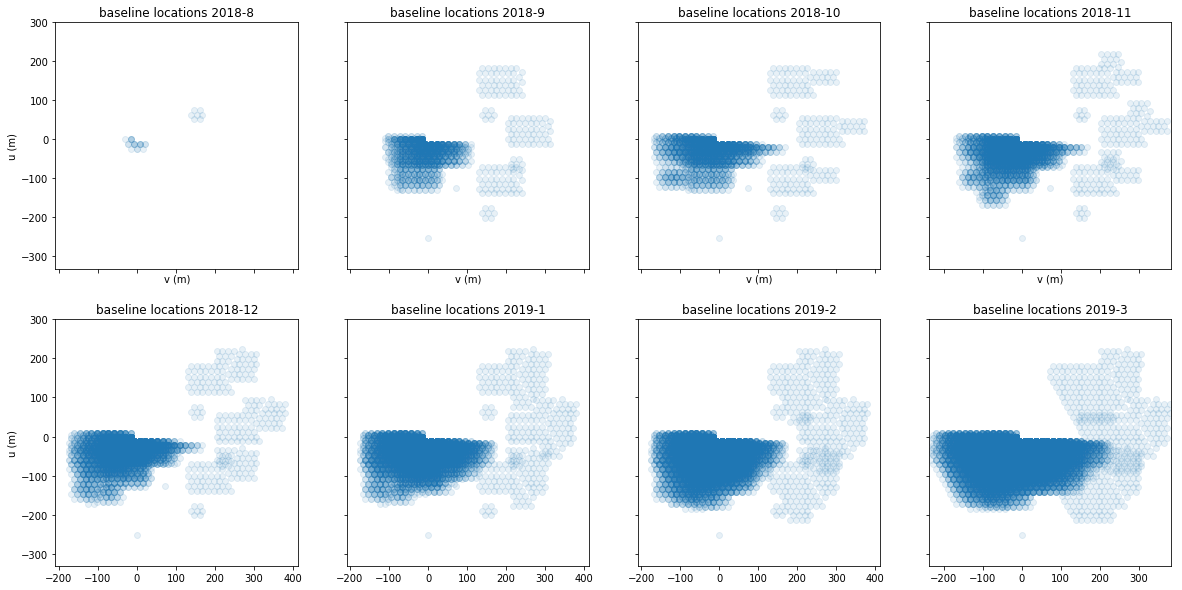

In [6]:
plot_ew = np.array([-1,1]) * np.ceil(np.max(abs(uvw_dict[n_files-1][:,0]), axis=0)/20)*20
plot_ns = np.array([-1,1]) * np.ceil(np.max(abs(uvw_dict[n_files-1][:,1]), axis=0)/20)*20

plt.figure(1)
fig, axes = plt.subplots(n_row, n_col, sharex='col', sharey='row')
for ind in range(n_files):
    row_num = ind % n_col
    col_num = ind / n_col
    uvw_array = uvw_dict[ind]
 
    axes[col_num, row_num].scatter(uvw_array[:, 0], uvw_array[:, 1], alpha=0.1)
    if row_num == 0:
        axes[col_num, row_num].set_ylabel("u (m)")
    if col_num == 0:
        axes[col_num, row_num].set_xlabel("v (m)")
    axes[col_num, row_num].set_aspect('equal', 'datalim')
    axes[col_num, row_num].set_title('baseline locations {yr}-{mo}'.format(yr=dates[ind].datetime.year,
                                                                           mo=dates[ind].datetime.month))

plt.show()
plt.close()

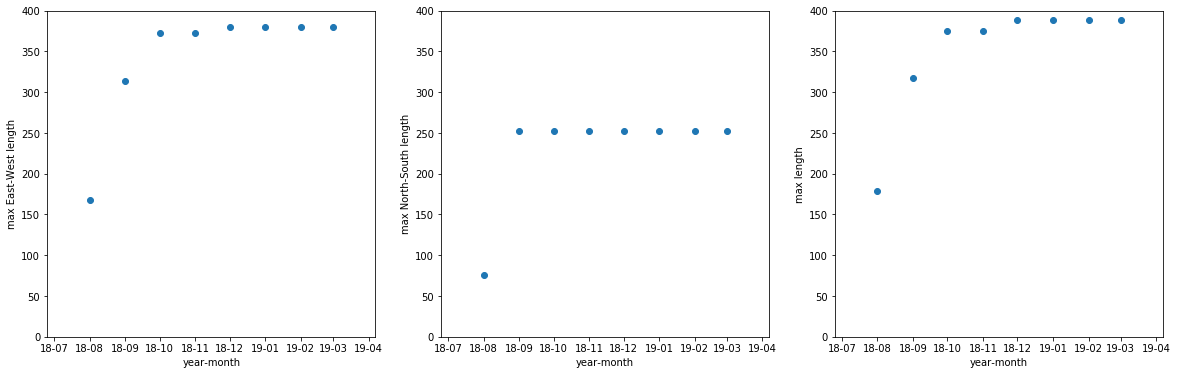

In [7]:
matplotlib.rcParams['figure.figsize'] = (20,6)
plot_dates = [date.datetime for date in dates]
month_format = mdates.DateFormatter('%y-%m')

plt.figure(1)
fig, axes = plt.subplots(1, 3)
axes[0].scatter(plot_dates, max_ew)
axes[0].set_xlabel("year-month")
axes[0].set_ylabel("max East-West length")
axes[0].set_ylim((0, 400))
axes[0].xaxis.set_major_formatter(month_format)

axes[1].scatter(plot_dates, max_ns)
axes[1].set_xlabel("year-month")
axes[1].set_ylabel("max North-South length")
axes[1].set_ylim((0, 400))
axes[1].xaxis.set_major_formatter(month_format)

axes[2].scatter(plot_dates, max_len)
axes[2].set_xlabel("year-month")
axes[2].set_ylabel("max length")
axes[2].set_ylim((0, 400))
axes[2].xaxis.set_major_formatter(month_format)

plt.show()
plt.close()

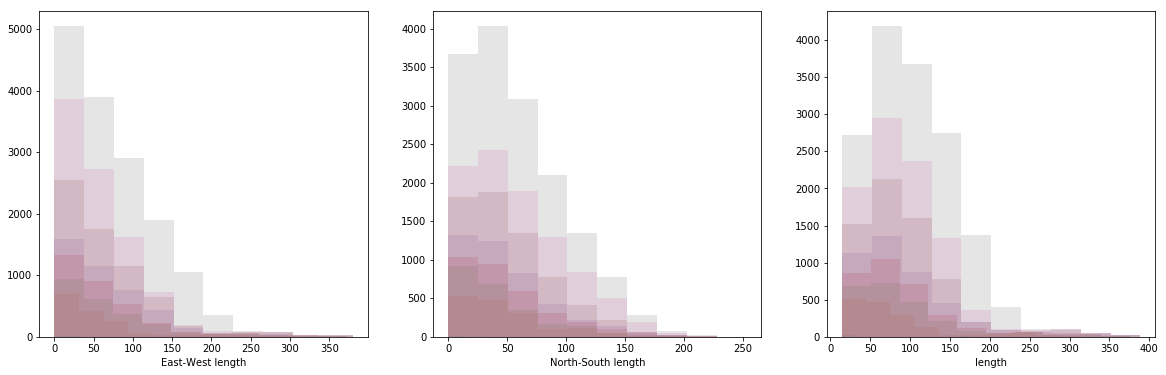

In [8]:
plt.figure(1)
plt.subplot(1, 3, 1)
for ind in range(n_files):
    uvw_array = uvw_dict[ind]
    plt.hist(abs(uvw_array[:,0]), alpha=0.2)
plt.xlabel("East-West length")

plt.subplot(1, 3, 2)
for ind in range(n_files):
    uvw_array = uvw_dict[ind]
    plt.hist(abs(uvw_array[:,1]), alpha=0.2)
plt.xlabel("North-South length")

plt.subplot(1, 3, 3)
for ind in range(n_files):
    uvw_array = uvw_dict[ind]
    plt.hist(np.linalg.norm(uvw_array, axis=1), alpha=0.2)
plt.xlabel("length")

plt.show()
plt.close()

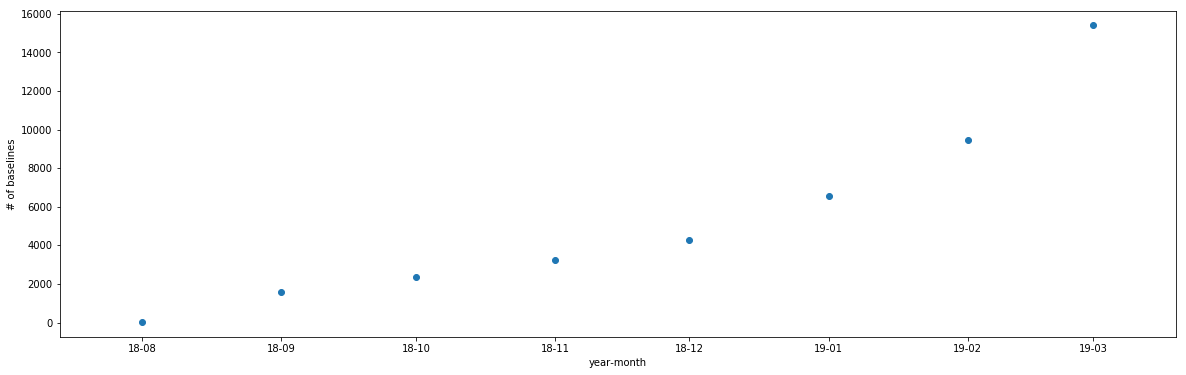

In [12]:
fig, axis = plt.subplots()
axis.scatter(plot_dates, n_baselines)
axis.set_xlabel("year-month")
axis.set_ylabel("# of baselines")
axis.xaxis.set_major_formatter(month_format)
